# Make corner plots: interactive way

In [3]:
import psutil
p = psutil.Process()
p.cpu_affinity([0])

import time
import numpy as np
import matplotlib.pyplot as plt 
import corner
import h5py
import jax.numpy as jnp
import json
import copy
from scipy.spatial.distance import jensenshannon
import pickle

from ripple import get_chi_eff, Mc_eta_to_ms, lambda_tildes_to_lambdas

import utils_compare_runs
from utils_compare_runs import paths_dict, jim_naming, LABELS

import seaborn as sns
import pandas as pd


default_corner_kwargs = dict(bins=40, 
                        smooth=1., 
                        show_titles=False,
                        label_kwargs=dict(fontsize=24),
                        title_kwargs=dict(fontsize=24), 
                        color="blue",
                        # quantiles=[],
                        levels=[0.68, 0.95], # 0.997
                        plot_density=False,
                        plot_datapoints=False, 
                        fill_contours=False,
                        max_n_ticks=4, 
                        min_n_ticks=3,
                        save=False,
                        labelpad = 0.075
)

params = {
    "axes.labelsize": 30,
    "axes.titlesize": 30,
    "text.usetex": True,
    "font.family": "serif",
    'xtick.labelsize': 16,
    'ytick.labelsize': 16
}
plt.rcParams.update(params)

## Preamble

In [4]:
save_path = "../figures/"
convert_chi = True
convert_lambdas = False
remove_tc = True
use_weights = False

## Plot

#### Plot preparation

Comparing runs for: GW170817_NRTidalv2
jim_path
/home/thibeau.wouters/TurboPE-BNS/real_events/GW170817_NRTidalv2/outdir/results_production.npz
bilby_path
/home/thibeau.wouters/jim_pbilby_samples/GW170817/GW170817_IMRDNRTv2_older_bilby_result.json
Reading bilby data
count
136095
Reading jim data
np.shape(chains) jim
(220000, 12)
Loading data complete
np.shape(samples)
(220000, 11)
np.shape(samples)
(45365, 11)
Now giving to turboPE function:
nsamp
100
Constructing dfs
Constructing dfs DONE
Preparing the plots
Preparing the plots DONE
Saving figure
Saving to: ../figures/GW170817_NRTidalv2.png
Saving to: ../figures/GW170817_NRTidalv2.pdf
Saving figure : DONE


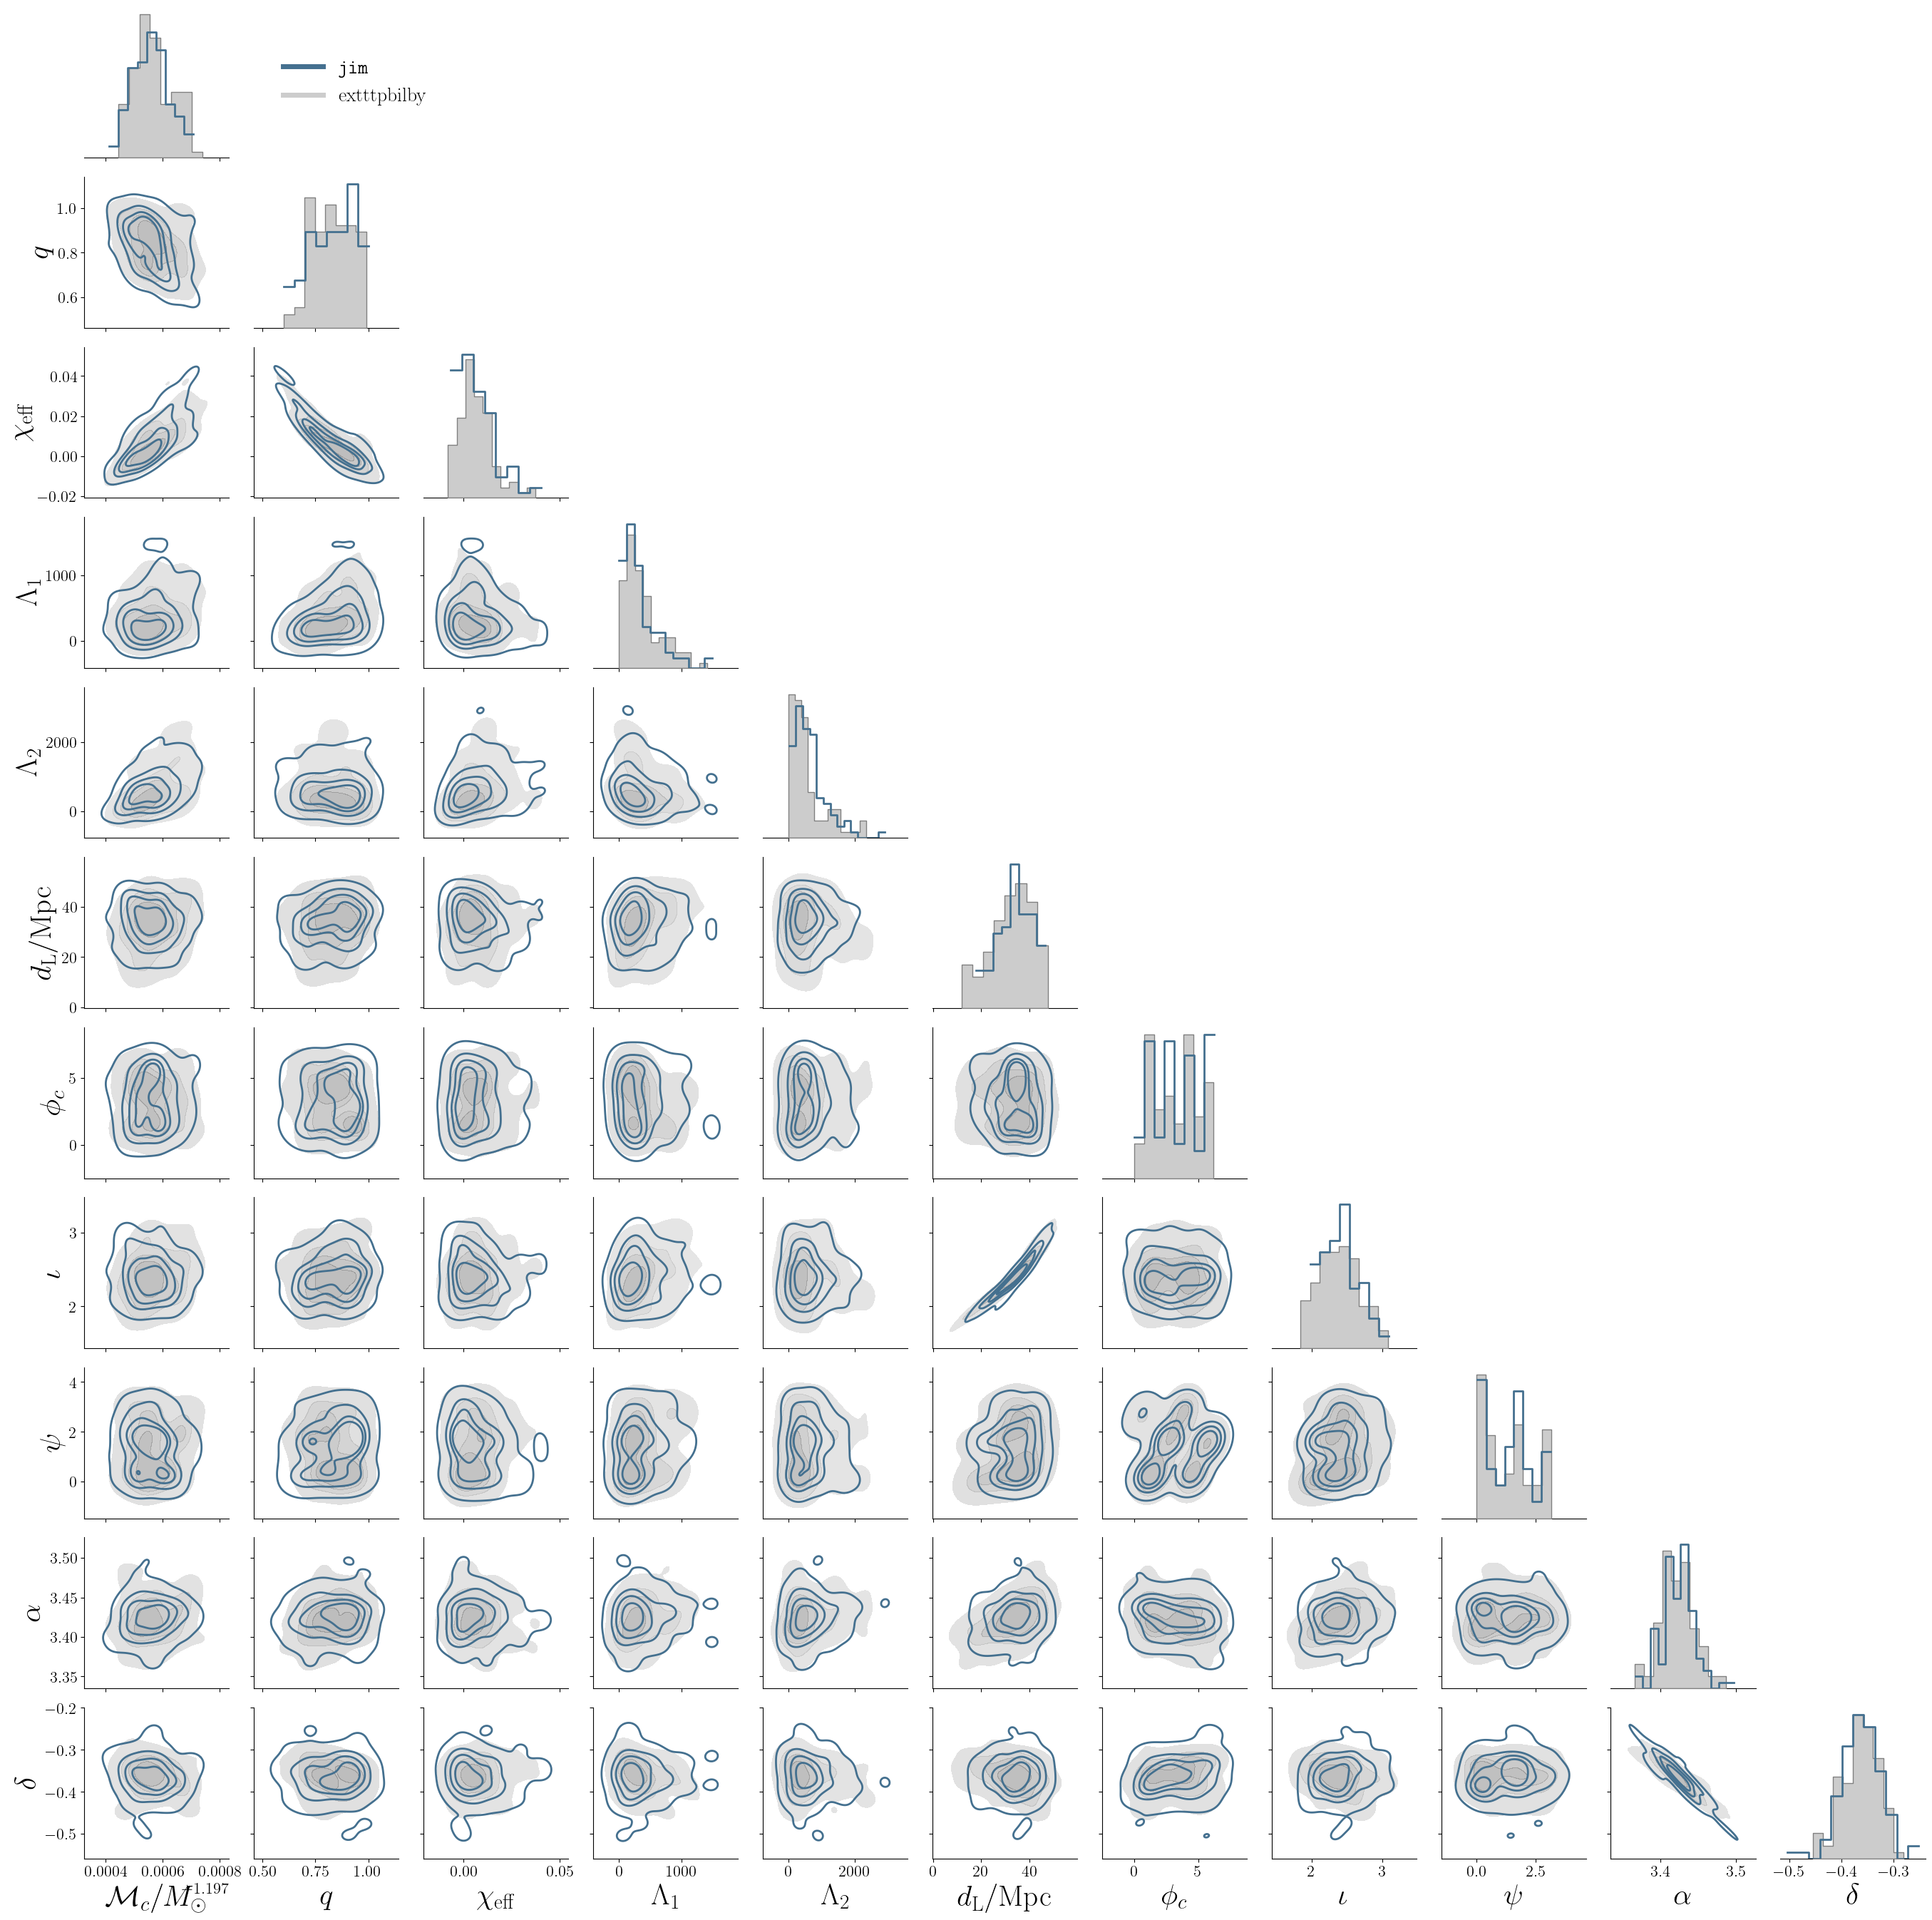

In [10]:
# events_to_plot = ["GW170817_TaylorF2",
#                   "GW170817_NRTidalv2",
#                   "GW190425_TaylorF2",
#                   "GW190425_NRTidalv2"]

events_to_plot = ["GW170817_NRTidalv2"]

for event, paths in paths_dict.items():
    save_name = f"../figures/{event}"
    
    # Skip the paths that we are not going to plot
    if event not in events_to_plot:
        continue
    
    print("==============================================")
    print(f"Comparing runs for: {event}")
    print("==============================================")
    jim_path = paths["jim"]
    bilby_path = paths["bilby"]
    
    print("jim_path")
    print(jim_path)
    
    print("bilby_path")
    print(bilby_path)
    
    if "TaylorF2" in jim_path:
        which_waveform = "TaylorF2"
    else:
        which_waveform = "PhenomDNRT"
    
    corner_kwargs = copy.deepcopy(default_corner_kwargs)
    
    # Fetch the desired kwargs from the specified dict
    range = utils_compare_runs.get_ranges(event, convert_chi, convert_lambdas)
    corner_kwargs["range"] = range
    idx_list = utils_compare_runs.get_idx_list(event, convert_chi = True, convert_lambdas = False)
    
    print("Reading bilby data")
    if ".h5" in bilby_path:
        bilby_samples = utils_compare_runs.get_chains_GWOSC(bilby_path, which_waveform=which_waveform)
    else:
        bilby_samples = utils_compare_runs.get_chains_bilby(bilby_path)

    print("Reading jim data")
    jim_samples = utils_compare_runs.get_chains_jim(jim_path, remove_tc = remove_tc)

    print("Loading data complete")

    jim_samples = utils_compare_runs.preprocess_samples(jim_samples, convert_chi = convert_chi, convert_lambdas = convert_lambdas)
    bilby_samples = utils_compare_runs.preprocess_samples(bilby_samples, convert_chi = convert_chi, convert_lambdas = convert_lambdas)
    
    # Remove the t_c label for comparison with bilby
    if remove_tc:
        labels = copy.deepcopy(LABELS)
        labels.remove(r'$t_c$')
    else:
        labels = LABELS
        
    if convert_lambdas:
        labels = copy.deepcopy(labels)
        labels.remove(r'$\Lambda_1$')
        labels.remove(r'$\Lambda_2$')
        labels.insert(4, r'$\tilde{\Lambda}$')
        labels.insert(5, r'$\delta\tilde{\Lambda}$')
    
    if convert_chi:
        labels = copy.deepcopy(labels)
        labels.remove(r'$\chi_1$')
        labels.remove(r'$\chi_2$')
        labels.insert(2, r'$\chi_{\rm eff}$')
        
    print("Now giving to turboPE function:")
    # lims = corner_kwargs["range"], TODO: change
    # This is the same as the previous function, but with the setup and plotting taken from TurboPE
    nsamp = 4000
    # Just rename for convenience
    jim_chains = jim_samples 
    bilby_chains = bilby_samples
    nsamp = min([nsamp, len(jim_chains), len(bilby_chains)])
    # TODO: change this manual override!
    nsamp = 100
    cline=sns.color_palette(desat=0.5)[0]
    lims = None
    
    print("nsamp")
    print(nsamp)
    
    # Downsample the jim and bilby chains with nsamp:
    jim_chains = jim_chains[np.random.choice(jim_chains.shape[0], nsamp, replace=False), :]
    bilby_chains = bilby_chains[np.random.choice(bilby_chains.shape[0], nsamp, replace=False), :]
    
    print("Constructing dfs")
    df1 = pd.DataFrame(jim_chains, columns=labels)#.sample(nsamp)
    df2 = pd.DataFrame(bilby_chains, columns=labels)#.sample(nsamp)
    print("Constructing dfs DONE")

    print("Preparing the plots")
    g = sns.PairGrid(df2, corner=True, diag_sharey=False)
    g.map_diag(sns.histplot, color='gray', alpha=0.4, element='step', fill=True)
    g.map_lower(sns.kdeplot, color='gray', alpha=0.4, levels=5, fill=True)

    g.data = df1
    g.map_diag(sns.histplot, color=cline, element='step', linewidth=2, fill=False)
    g.map_lower(sns.kdeplot, color=cline, levels=5, linewidths=2)
    print("Preparing the plots DONE")
    
    # set axis limits
    if lims is not None:
        for i, axes in enumerate(g.axes):
            for j, ax in enumerate(axes):
                if ax is not None:
                    if lims[j]:
                        ax.set_xlim(lims[j])
                    if lims[i] and i != j:
                        ax.set_ylim(lims[i])

    # add legend
    ax = g.axes[0,0]
    legend_lw = 5
    ax.plot([], [], color=cline, lw=legend_lw, label=r"\texttt{jim}")
    ax.plot([], [], color='gray', alpha=0.4, lw=legend_lw, label="\texttt{pbilby}")
    ax.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), frameon=False,
                fontsize=20)

    # Save the figure
    print("Saving figure")
    for ext in ["png", "pdf"]:
        this_save_name = f"{save_name}.{ext}"
        print(f"Saving to: {this_save_name}")
        plt.savefig(this_save_name, bbox_inches='tight')
        
    print("Saving figure : DONE")
    plt.show()

#### Plot tuning

Saving figure
Saving to: ../figures/GW190425_NRTidalv2_online_data.png
Saving to: ../figures/GW190425_NRTidalv2_online_data.pdf
Saving figure : DONE


<Figure size 640x480 with 0 Axes>